<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

Alumno: Sofia Speri

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

#### Librerías

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296187 sha256=7d18a1ee7af6cd54f03aef4a9cf06ded04133578191e2e0067701bcb08130c26
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [3]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Input, Dense, Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.layers import Input

from gensim.models import FastText
from gensim.test.utils import common_texts
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 220MB/s]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [8]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [9]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [10]:
#Tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [11]:
# tokenizador de entrada
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


In [12]:
# tokenizador de salida
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1806
Sentencia de salida más larga: 10


#### Padding
Encoder paddea al comienzo, decoder al final

In [13]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)


Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


In [45]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("decoder_targets_sequences shape:",decoder_targets.shape)

decoder_targets_sequences shape: (6033, 10, 1807)


### 3 - Preparar los embeddings
Descargo modelo de dimensió 300 de fasttext (por velocidad de descarga lo carga de manera local)
Para procesamiento, reduzco dimensión de los embeddings a 100

In [15]:
import fasttext
import fasttext.util

# Descargar y cargar el modelo de FastText
#fasttext.util.download_model('en', if_exists='ignore')
model = fasttext.load_model('/content/drive/MyDrive/CEIA/PNL/Desafio 4/cc.en.300.bin')
#Reducción de dimesión a 100 par el ejercicio
model_embeddings = fasttext.util.reduce_model(model, 100)

In [20]:
print('preparing embedding matrix...')
embed_dim = model_embeddings.get_dimension()
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue

    embedding_vector = model_embeddings.get_word_vector(word)
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [21]:
embedding_matrix.shape

(1799, 100)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

#### Definición del modelo

In [25]:
n_units = 128 #Valor recomendado

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 9, 100)         │        179,900 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 10, 128)        │        231,296 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 128), (None,   │        117,248 │ embedding_1[0][0]      │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 10, 128),      │        131,584 │ embedding_2[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm_1[0][1],          │
│                           │ 128)]                  │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 10, 1807)       │        233,103 │ lstm_2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 893,131 (3.41 MB)

 Trainable params: 713,231 (2.72 MB)

 Non-trainable params: 179,900 (702.73 KB)

In [26]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

#### Entrenamiento del modelo

In [35]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7994 - loss: 0.8919 - val_accuracy: 0.7375 - val_loss: 1.6763
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8032 - loss: 0.8670 - val_accuracy: 0.7371 - val_loss: 1.6795
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8070 - loss: 0.8578 - val_accuracy: 0.7367 - val_loss: 1.6854
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8078 - loss: 0.8492 - val_accuracy: 0.7383 - val_loss: 1.6905
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8061 - loss: 0.8474 - val_accuracy: 0.7369 - val_loss: 1.6984
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8082 - loss: 0.8443 - val_accuracy: 0.7367 - val_loss: 1.6972
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8161 - loss: 0.8036 - val_accuracy: 0.7376 - val_loss: 1.7057
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8147 - loss: 0.8111 - val_accuracy: 0.

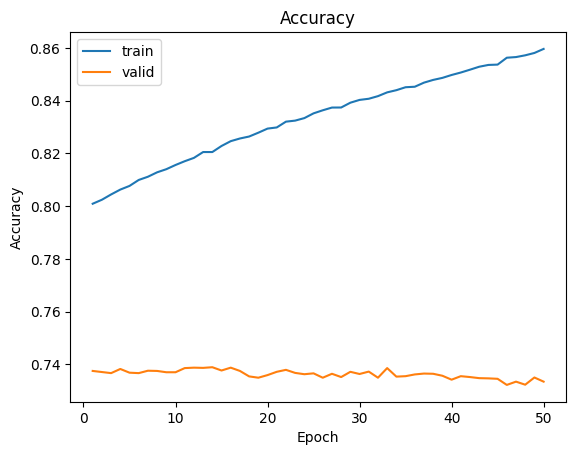

In [36]:
# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [37]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [38]:
def translate_sentence(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

#### Prueba Random

In [39]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
-
Input: nice do you have any hobbies 
Response: i like to play video games


#### Prueba "Do you read?"
Vemos que responde de manera lógica, aunque es la misma rspuesta a la pregunta anterior de "do you have any hobbies"

In [40]:
input_test = "Do you read?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Do you read?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Response: i like to play video games


#### Prueba "How old are you?"
Responde correctamente, pero el largo de la secuencia en este caso falló porque repitió la respuesta

In [41]:
input_test = "How old are you?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: How old are you?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Response: i am 32 i am 32


#### Prueba "Where do yoy come from?"

Ante el error de tipeo, no reconoce la pregunta y responde en consecuencia

In [42]:
input_test = "Where do yoy come from?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Where do yoy come from?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Response: i do not know what to say


Prueba "Do you have any pet?"

In [43]:
input_test = "Do you have any pet?"
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

print('Input:', input_test)
translation = translate_sentence(encoder_sequence_test)
print('Response:', translation)

Input: Do you have any pet?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Response: i have two dogs
